In [1]:
# Install capstone
!git clone -b colab-friendly-5 https://github.com/vishu-tyagi/JNJ-Capstone-Project.git
%cd JNJ-Capstone-Project/src/capstone

!python setup.py install

import os, sys
sys.path.append(os.getcwd())

# install unavailable packages
!pip install boto3

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# ! pip install nltk
# !pip uninstall transformers
# !pip uninstall torchtext
# !pip uninstall pytorch-lightning
# !pip uninstall torch
!pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2
!pip install transformers==4.5.1 --quiet
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

# Move to notebooks directory
%cd ../../notebooks

fatal: destination path 'JNJ-Capstone-Project' already exists and is not an empty directory.
/content/JNJ-Capstone-Project/src/capstone
running install
running bdist_egg
running egg_info
writing capstone.egg-info/PKG-INFO
writing dependency_links to capstone.egg-info/dependency_links.txt
writing top-level names to capstone.egg-info/top_level.txt
writing manifest file 'capstone.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/capstone
creating build/bdist.linux-x86_64/egg/capstone/evaluation
copying build/lib/capstone/evaluation/evaluation.py -> build/bdist.linux-x86_64/egg/capstone/evaluation
copying build/lib/capstone/evaluation/__init__.py -> build/bdist.linux-x86_64/egg/capstone/evaluation
copying build/lib/capstone/__main__.py -> build/bdist.linux-x86_64/egg/capstone
copying build/lib/capstone/api.py -> build/bdist.linux-x86_64/egg/capstone
c

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/JNJ-Capstone-Project/notebooks


In [2]:
!nvidia-smi

Mon Nov 14 12:17:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
from pathlib import Path
import logging
import itertools
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.evaluation import CustomEvaluation
from capstone.utils.constants import (
    TEXT,
    TARGET,
    ORIGINAL_TEXT,
    SPLIT,
    DEVELOP,
    TEST
)

device = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

In [4]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

,Text,Standard mapping?
0,General Quality System Requirements […] Manage...,"[quality management, quality planning]"
1,General Quality System Requirements […] Manage...,[quality management]
2,General Quality System Requirements […] Manage...,[quality management]


In [5]:
features = Features(config)
df_features = features.build(df)

df_features.head(3)

,Text,Standard mapping?,Original Text,audit inspection,calibration,capa,change controls,clinical research,controled substances,csv,...,word__unit generally,word__unit generally shared,word__use device,word__used manufacture,word__used production,word__validation study,word__way ensures,word__wholesale distributor,word__written procedure,Split
0,good practice quality control qc responsibilit...,"[laboratory controls, stability programs]",Good practices in quality control […] Other QC...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.439675,Development
1,good practice quality control basic requiremen...,"[capa, nc, rca]",Good practices in quality control […] The basi...,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,Development
2,validation process validation program critical...,[process & packaging validation],Validation […] Process Validation Program […] ...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.285952,0.0,0.0,0.000000,Development


In [6]:
dev = df_features[df_features[SPLIT].isin([DEVELOP])].copy()
Y_dev = dev[features.mlb.classes_].copy()

test = df_features[df_features[SPLIT].isin([TEST])].copy()
Y_test = test[features.mlb.classes_].copy()

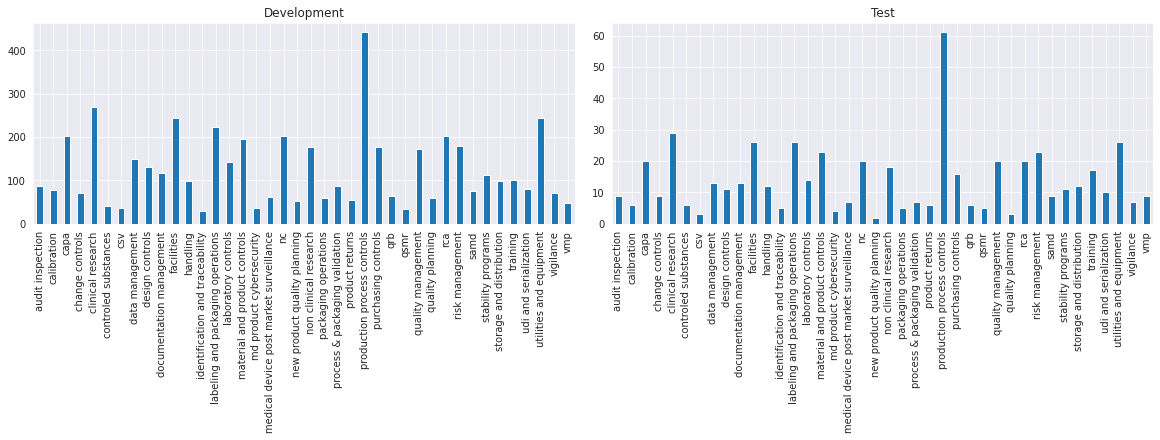

In [7]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
Y_dev.sum(axis=0).plot.bar(ax=ax[0])
Y_test.sum(axis=0).plot.bar(ax=ax[1])
ax[0].set_title("Development")
ax[1].set_title("Test");

In [8]:
train, val, _, _ = train_test_split(
    dev, dev[features.mlb.classes_].to_numpy(), test_size=.1, shuffle=True, random_state=64
)

Y_train = train[features.mlb.classes_].copy()
Y_val = val[features.mlb.classes_].copy()

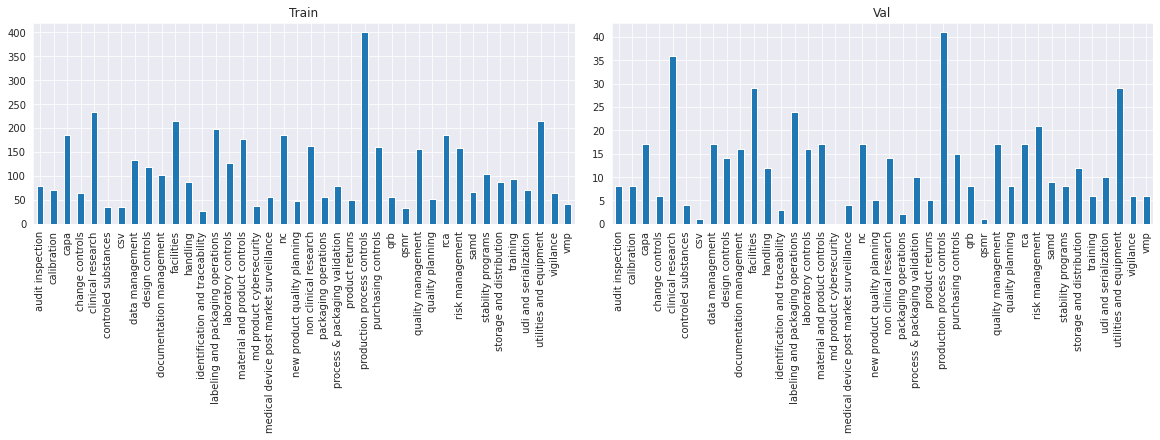

In [9]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
Y_train.sum(axis=0).plot.bar(ax=ax[0])
Y_val.sum(axis=0).plot.bar(ax=ax[1])
ax[0].set_title("Train") 
ax[1].set_title("Val");

In [10]:
class JJDataset(Dataset):
  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: AutoTokenizer, 
    max_length: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_length = max_length
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    row = self.data.iloc[index]
    text = row[ORIGINAL_TEXT]
    target = row[features.mlb.classes_]

    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_length,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_token_type_ids=True,
      return_tensors='pt'
    )

    return {
        "input_ids": inputs["input_ids"].flatten(),
        "attention_mask": inputs["attention_mask"].flatten(),
        "token_type_ids": inputs["token_type_ids"].flatten(),
        "target": torch.FloatTensor(target)
    }


In [11]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)


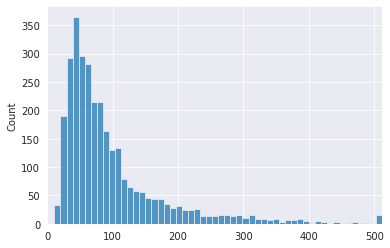

In [12]:
token_counts = []
for _, row in train.iterrows():
    tokens = tokenizer.encode(
        row[ORIGINAL_TEXT],
        max_length=512,
        truncation=True
    )
    token_counts.append(len(tokens))

sns.histplot(token_counts)
plt.xlim([0, 512]);

In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = AutoModel.from_pretrained(BERT_MODEL_NAME)
        self.l2 = nn.Dropout(0.3)
        self.l3 = nn.Linear(self.l1.config.hidden_size, len(features.mlb.classes_))
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.l1(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        out = self.l2(out.pooler_output)
        out = self.l3(out)
        return out

model = Model()
model.to(device);

In [14]:
MAX_TOKEN_COUNT = 256
TRAIN_BATCH = 12
VALID_BATCH_SIZE = 8
EPOCHS = 40
LEARNING_RATE = 1e-05
NUM_WORKERS = 0

In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
saved_models_path = os.path.join(data.current_path, "saved_models_MLP")

!mkdir ../saved_models_MLP

mkdir: cannot create directory ‘../saved_models_MLP’: File exists


In [16]:
train_dataset = JJDataset(
  train,
  tokenizer,
  max_length=MAX_TOKEN_COUNT
)
valid_dataset = JJDataset(
  val,
  tokenizer,
  max_length=MAX_TOKEN_COUNT
)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=TRAIN_BATCH, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=VALID_BATCH_SIZE, num_workers=NUM_WORKERS)

In [17]:
# Move model to device
model.to(device)
# Lists to keep the losses and evaluation scores at the end of each epoch
train_loss, valid_loss = list(), list()
for epoch in range(EPOCHS):
    # Dummy lists to keep the losses and evaluation scores at the end of each iteration
    # (one batch forward and backward process)
    train_batch_loss, valid_batch_loss = list(), list()
    # Training mode
    model.train()
    for i, item in enumerate(train_loader):
        # Move input to device
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)
        # Forward pass
        out = model(input_ids, attention_mask, token_type_ids)
        # Calculate loss
        loss = criterion(out, target)
        # Reset gradients
        optimizer.zero_grad()
        # Backward pass (backpropogation)
        loss.backward()
        # Update weights
        optimizer.step()
        # Collect loss and evaluation scores
        train_batch_loss.append(loss.item())
        message = \
            f"EPOCH:{epoch+1}/{EPOCHS}, " + \
            f"step:{i+1}/{len(train_loader)}, " + \
            f"loss={loss.item()}"
        print("\r", message, end="")
    # Take the average of iteration losses and evaluation scores
    # and append it to the epoch losses list
    train_loss.append(np.array(train_batch_loss).mean())
    # Evaluation mode
    model.eval()
    with torch.no_grad():
        for i, item in enumerate(valid_loader):
            # Move input to device
            input_ids = item["input_ids"].to(device, dtype=torch.long)
            attention_mask = item["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
            target = item["target"].to(device, dtype=torch.float)
            # Forward pass
            out = model(input_ids, attention_mask, token_type_ids)
            # Calculate loss
            loss = criterion(out, target)
            valid_batch_loss.append(loss.item())
            message = \
                f"EPOCH:{epoch+1}/{EPOCHS}, " + \
                f"step:{i+1}/{len(valid_loader)}, " + \
                f"loss={loss.item()}"
            print("\r", message, end="")
    # Take the average of iteration losses and evaluation scores
    # and append it to the epoch losses list
    valid_loss.append(np.array(valid_batch_loss).mean())
    message = \
        f"EPOCH:{epoch+1}/{EPOCHS} - " + \
        f"Training Loss: {train_loss[-1]}, " + \
        f"Validation Loss: {valid_loss[-1]}"
    print("\r", message)
    # Save model
    state = f"epoch_{epoch+1:03}.pth"
    state_dict_path = os.path.join(saved_models_path, state)
    torch.save(model.state_dict(), state_dict_path)


 EPOCH:1/40 - Training Loss: 0.314988461873246, Validation Loss: 0.18333482335914264
 EPOCH:2/40 - Training Loss: 0.1700243398719773, Validation Loss: 0.1527023852210153
 EPOCH:3/40 - Training Loss: 0.1519467037271809, Validation Loss: 0.1422011007300832
 EPOCH:4/40 - Training Loss: 0.1407745771081291, Validation Loss: 0.1302517789670012
 EPOCH:5/40 - Training Loss: 0.12708649873503386, Validation Loss: 0.11757726493206891
 EPOCH:6/40 - Training Loss: 0.11189818485823377, Validation Loss: 0.10645700584758412
 EPOCH:7/40 - Training Loss: 0.09856075917201614, Validation Loss: 0.09741580139168284
 EPOCH:8/40 - Training Loss: 0.08728227062460078, Validation Loss: 0.08822690602391958
 EPOCH:9/40 - Training Loss: 0.0775704885685536, Validation Loss: 0.08291733417321336
 EPOCH:10/40 - Training Loss: 0.06943681170178656, Validation Loss: 0.07764008666642687
 EPOCH:11/40 - Training Loss: 0.06185770988406822, Validation Loss: 0.07506677753884684
 EPOCH:12/40 - Training Loss: 0.055537153646695106

In [18]:
best_epoch = np.argmin(valid_loss) + 1
print(f"Best epoch: {best_epoch}")
state = f"epoch_{best_epoch:03}.pth"
state_dict_path = os.path.join(saved_models_path, state)
state_dict = torch.load(state_dict_path)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

Best epoch: 23


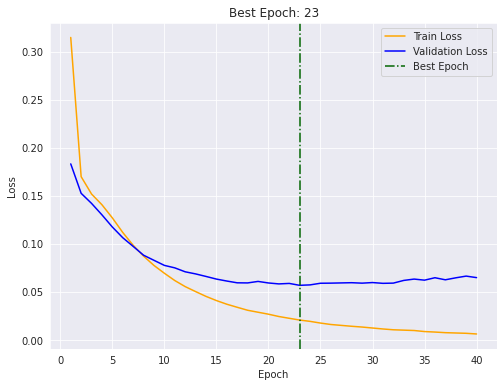

In [19]:
fig = plt.figure(figsize=(8, 6))
plt.plot(range(1, EPOCHS+1), train_loss, label="Train Loss", color="orange")
plt.plot(range(1, EPOCHS+1), valid_loss, label="Validation Loss", color="blue")
plt.axvline(x=best_epoch, label="Best Epoch", color="darkgreen", linestyle="dashdot")
plt.xlabel("Epoch")
plt.ylabel(f"Loss")
plt.title(f"Best Epoch: {best_epoch}")
plt.legend(loc="upper right");

In [20]:
valid_dataset = JJDataset(
  val,
  tokenizer,
  max_length=MAX_TOKEN_COUNT
)

valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)
 
y_true = []
y_pred_probab = []

with torch.no_grad():
    for i, item in enumerate(valid_loader):
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)

        out = model(input_ids, attention_mask, token_type_ids)
        out = torch.sigmoid(out)

        y_true.append(target.to("cpu").numpy().reshape(-1,))
        y_pred_probab.append(out.to("cpu").numpy().reshape(-1,))

In [21]:
y_true_val = np.array(y_true).astype(int)
y_pred_probab_val = np.array(y_pred_probab)

In [22]:
eval = CustomEvaluation()

In [23]:
thresholds = eval.threshold_discovery(y_true_val, y_pred_probab_val)

In [24]:
list(zip(features.mlb.classes_, thresholds))

[('audit inspection', 0.3),
 ('calibration', 0.25),
 ('capa', 0.1),
 ('change controls', 0.1),
 ('clinical research', 0.1),
 ('controled substances', 0.1),
 ('csv', 0.15),
 ('data management', 0.45),
 ('design controls', 0.1),
 ('documentation management', 0.3),
 ('facilities', 0.15),
 ('handling', 0.7),
 ('identification and traceability', 0.15),
 ('labeling and packaging operations', 0.1),
 ('laboratory controls', 0.1),
 ('material and product controls', 0.3),
 ('md product cybersecurity', 0.5),
 ('medical device post market surveillance', 0.2),
 ('nc', 0.1),
 ('new product quality planning', 0.25),
 ('non clinical research', 0.35),
 ('packaging operations', 0.5),
 ('process & packaging validation', 0.5),
 ('product returns', 0.15),
 ('production process controls', 0.15),
 ('purchasing controls', 0.1),
 ('qrb', 0.35),
 ('qsmr', 0.35),
 ('quality management', 0.2),
 ('quality planning', 0.3),
 ('rca', 0.1),
 ('risk management', 0.1),
 ('samd', 0.1),
 ('stability programs', 0.3),
 ('st

In [25]:
y_pred_val = np.where(y_pred_probab_val > thresholds, 1, 0)

eval.compute_sample_wise_metrics(y_true=y_true_val, y_pred=y_pred_val)

Hamming Loss    0.013043
Accuracy        0.701449
Precision       0.850180
Recall          0.873768
F1 Score        0.843268
F2 Score        0.855576
dtype: float64

In [26]:
test_dataset = JJDataset(
  test,
  tokenizer,
  max_length=MAX_TOKEN_COUNT
)

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)
 
y_true = []
y_pred_probab = []

with torch.no_grad():
    for i, item in enumerate(test_loader):
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)

        out = model(input_ids, attention_mask, token_type_ids)
        out = torch.sigmoid(out)

        y_true.append(target.to("cpu").numpy().reshape(-1,))
        y_pred_probab.append(out.to("cpu").numpy().reshape(-1,))

In [27]:
y_true_test = np.array(y_true).astype(int)
y_pred_probab_test = np.array(y_pred_probab)
y_pred_test = np.where(y_pred_probab_test > thresholds, 1, 0)

In [29]:
eval.compute_sample_wise_metrics(y_true=y_true_test, y_pred=y_pred_test)

Hamming Loss    0.014323
Accuracy        0.690104
Precision       0.847786
Recall          0.881923
F1 Score        0.841620
F2 Score        0.857612
dtype: float64

In [28]:
eval.compute_label_wise_metrics(
    y_true=y_true_test,
    y_pred=y_pred_test,
    labels=features.mlb.classes_,
    dev_samples=Y_dev.to_numpy().sum(axis=0).tolist()
)

,Precision,Recall,F1 Score,F2 Score,Development Samples,Test Samples
audit inspection,0.800000,0.888889,0.842105,0.869565,86,9
calibration,0.800000,0.666667,0.727273,0.689655,78,6
capa,0.760000,0.950000,0.844444,0.904762,202,20
change controls,0.666667,0.888889,0.761905,0.833333,71,9
clinical research,0.931034,0.931034,0.931034,0.931034,269,29
controled substances,1.000000,0.833333,0.909091,0.862069,40,6
csv,0.250000,0.333333,0.285714,0.312500,37,3
data management,0.722222,1.000000,0.838710,0.928571,150,13
design controls,0.692308,0.818182,0.750000,0.789474,132,11
documentation management,0.833333,0.769231,0.800000,0.781250,117,13
